In [1]:
# matplotlib notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

In [2]:
datadir = '/scr/babaie/gem5art-experiments/results/'
plotdir = '/scr/babaie/gem5art-experiments/images/'

In [3]:
# SPEC2006 Benchmarks
spec2017_benchmarks = ['500.perlbench_r', '502.gcc_r', '503.bwaves_r', '505.mcf_r', '507.cactuBSSN_r', '508.namd_r', 
                       '510.parest_r', '511.povray_r', '519.lbm_r', '520.omnetpp_r', '521.wrf_r', '523.xalancbmk_r', 
                       '525.x264_r', '526.blender_r', '527.cam4_r', '531.deepsjeng_r', '538.imagick_r', '541.leela_r', 
                       '544.nab_r', '548.exchange2_r', '549.fotonik3d_r', '554.roms_r', '557.xz_r', '600.perlbench_s', 
                       '602.gcc_s', '603.bwaves_s', '605.mcf_s', '607.cactuBSSN_s', '619.lbm_s', '620.omnetpp_s', '621.wrf_s', 
                       '623.xalancbmk_s', '625.x264_s', '627.cam4_s', '628.pop2_s', '631.deepsjeng_s', '638.imagick_s', 
                       '641.leela_s', '644.nab_s', '648.exchange2_s', '649.fotonik3d_s', '654.roms_s', '657.xz_s', 
                       '996.specrand_fs', '997.specrand_fr', '998.specrand_is', '999.specrand_ir']


In [4]:
cpus = ['kvm', 'atomic', 'timing', 'o3']
datasize = ['test', 'ref']
# gem5_version = ['gem5-19', 'gem5-20']
gem5_version = ['gem5-20']

In [5]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try:
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except:
        return 0

In [6]:
def getStatus(filename):
    out_file = os.path.join(datadir, '', filename, 'simout').replace('\\','/')
    err_file = os.path.join(datadir, '', filename, 'simerr').replace('\\','/')
    sys_file = os.path.join(datadir, '', filename, 'system.pc.com_1.device').replace('\\','/')
    status = ''
    try:
        with open(out_file) as f:
            lines = f.readlines()
            l_line = lines[-1]
            l2_line = lines[-2]
            l3_line = lines[-3]
            if 'Booting Linux' in l_line:
                status = 'booting'
            elif 'switching cpus' in l_line:
                status = 'switching'
            elif 'Start running benchmark' in l_line:
                status = 'running'
            elif 'Output stats' in l_line:
                status = 'success'
            elif ('Copying done!' in l_line or 'Copying SPEC logs!' in l2_line):
                status = 'No log'
            elif 'Copying done' in l_line:
                status = 'success'
            elif 'Error while running benchmark: user interrupt received' in l_line:
                status = 'interrupted'
            else:
                status = 'failure'
    except: #temporary change
        status = 'to-run'

    try:
        with open(err_file) as f:
            l_line = f.readlines()[-1]
            if '--- END LIBC BACKTRACE ---' in l_line:
                status = 'sim-crash'
    except:
        status = 'to-run'

    try:
        with open(sys_file) as f:
            l_line = f.readlines()[-1]
            if '---[ end Kernel panic' in l_line:
                status = 'kernel-panic'
    except:
        status = 'to-run'

    return status

In [7]:
# data frame for KVM CPU
rows = []
temp = ['test']
for gem5 in gem5_version:
    for size in temp:
        cdir = datadir + cpus[0] + '/' + size + '/'
        for bm in spec2017_benchmarks:
            rows.append([gem5,size, bm,
                             gem5GetStat(cdir + bm, 'sim_ticks')/435, #1000
                             gem5GetStat(cdir + bm, 'sim_insts'),
                             gem5GetStat(cdir + bm, 'sim_ops'),
                             gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                             gem5GetStat(cdir + bm, 'host_seconds'),
                             getStatus(cdir + bm)])

df_kvm = pd.DataFrame(rows, columns=['gem5','data_size', 'benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_seconds', 'status'])
df_kvm['host_mins'] = df_kvm['host_seconds']/60
df_kvm['host_hours'] = df_kvm['host_seconds']/3600
df_kvm['insts_per_billion'] = df_kvm['instructions']/1000000000
df_kvm['ipc'] = df_kvm['instructions']/df_kvm['cycles']
df_kvm['cpi'] = df_kvm['cycles']/df_kvm['instructions']
df_kvm['opc'] = df_kvm['ops']/df_kvm['cycles']

In [8]:
rows = []
temp = ['ref']
for gem5 in gem5_version:
    for size in temp:
        cdir = datadir + cpus[0] + '/' + size + '/'
        for bm in spec2017_benchmarks:
            rows.append([gem5,size, bm,
                             gem5GetStat(cdir + bm, 'sim_ticks')/435, #1000
                             gem5GetStat(cdir + bm, 'sim_insts'),
                             gem5GetStat(cdir + bm, 'sim_ops'),
                             gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                             gem5GetStat(cdir + bm, 'host_seconds'),
                             getStatus(cdir + bm)])

df_kvm_r = pd.DataFrame(rows, columns=['gem5','data_size', 'benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_seconds', 'status'])
df_kvm_r['host_mins'] = df_kvm_r['host_seconds']/60
df_kvm_r['host_hours'] = df_kvm_r['host_seconds']/3600
df_kvm_r['insts_per_billion'] = df_kvm_r['instructions']/1000000000
df_kvm_r['ipc'] = df_kvm_r['instructions']/df_kvm_r['cycles']
df_kvm_r['cpi'] = df_kvm_r['cycles']/df_kvm_r['instructions']
df_kvm_r['opc'] = df_kvm_r['ops']/df_kvm_r['cycles']

In [9]:
# data frame for Atomic CPU
rows = []
temp = ['test']
for gem5 in gem5_version:
    for size in temp:
        cdir = datadir + '/results/new/' + cpus[1] + '/' + size + '/'
        for bm in spec2017_benchmarks:
            rows.append([gem5, size, bm,
                             gem5GetStat(cdir + bm, 'sim_ticks')/435, #1000
                             gem5GetStat(cdir + bm, 'sim_insts'),
                             gem5GetStat(cdir + bm, 'sim_ops'),
                             gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                             gem5GetStat(cdir + bm, 'host_seconds'),
                             getStatus(cdir + bm)])

df_atomic = pd.DataFrame(rows, columns=['gem5','data_size','benchmark','cycles', 'instructions', 'ops', 'sim_time', 'host_seconds','status'])
df_atomic['host_mins'] = df_atomic['host_seconds']/60
df_atomic['host_hours'] = df_atomic['host_seconds']/3600
df_atomic['insts_per_billion'] = df_atomic['instructions']/1000000000
df_atomic['ipc'] = df_atomic['instructions']/df_atomic['cycles']
df_atomic['cpi'] = df_atomic['cycles']/df_atomic['instructions']
df_atomic['opc'] = df_atomic['ops']/df_atomic['cycles']

In [10]:
# data frame for Timing CPU
rows = []
temp = ['test']
for gem5 in gem5_version:
    for size in temp:
        cdir = datadir + cpus[2] + '/' + size + '/'
        for bm in spec2017_benchmarks:
            rows.append([gem5, size, bm,
                             gem5GetStat(cdir + bm, 'sim_ticks')/435, #1000
                             gem5GetStat(cdir + bm, 'sim_insts'),
                             gem5GetStat(cdir + bm, 'sim_ops'),
                             gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                             gem5GetStat(cdir + bm, 'host_seconds'),
                             gem5GetStat(cdir + bm, 'system.detailed_cpu.numCycles'),
                             gem5GetStat(cdir + bm, 'system.detailed_cpu.committedInsts'),
                             getStatus(cdir + bm)])

df_timing = pd.DataFrame(rows, columns=['gem5','data_size','benchmark','total_cycles', 'total_instructions', 'ops',
                                        'sim_time','host_seconds', 'cycles', 'instructions', 'status'])
df_timing['host_mins'] = df_timing['host_seconds']/60
df_timing['host_hours'] = df_timing['host_seconds']/3600
df_timing['insts_per_billion'] = df_timing['instructions']/1000000000
df_timing['cpi'] = df_timing['cycles']/df_timing['instructions']

In [11]:
# data frame for O3 CPU
rows = []
temp = ['test']
for gem5 in gem5_version:
    for size in temp:
        cdir = datadir + cpus[3] + '/' + size + '/'
        for bm in spec2017_benchmarks:
            rows.append([gem5, size, bm,
                     gem5GetStat(cdir + bm, 'sim_ticks')/435, #1000
                     gem5GetStat(cdir + bm, 'sim_insts'),
                     gem5GetStat(cdir + bm, 'sim_ops'),
                     gem5GetStat(cdir + bm, 'sim_ticks')/1e12,
                     gem5GetStat(cdir + bm, 'host_seconds'),
                     gem5GetStat(cdir + bm, 'system.detailed_cpu.commit.committedInsts'),
                     gem5GetStat(cdir + bm, 'system.detailed_cpu.cpi'),
                     gem5GetStat(cdir + bm, 'system.cpu.icache.overall_miss_rate::total')*100,
                     gem5GetStat(cdir + bm, 'system.cpu.dcache.overall_miss_rate::total')*100,
                     gem5GetStat(cdir + bm, 'system.cpu.l2cache.overall_miss_rate::total')*100,
                     gem5GetStat(cdir + bm, 'system.l3cache.overall_miss_rate::total')*100,
                     gem5GetStat(cdir + bm, 'system.detailed_cpu.commit.branches'),
                     gem5GetStat(cdir + bm, 'system.detailed_cpu.commit.branchMispredicts'),
                     getStatus(cdir + bm)])
   
                                         
df_o3 = pd.DataFrame(rows, columns=['gem5', 'data_size', 'benchmark','cycles', 'total_instructions', 'ops', 'sim_time', 
                                    'host_seconds','committed_instructions','cpi','icache_miss_rate', 'dcache_miss_rate',
                                    'l2cache_miss_rate', 'l3cache_miss_rate', 'branches', 'branchMispredicts', 'status'])
df_o3['ipc'] = 1/df_o3['cpi']
df_o3['host_mins'] = df_o3['host_seconds']/60
df_o3['host_hours'] = df_o3['host_seconds']/3600
df_o3['insts_per_billion'] = df_o3['committed_instructions']/1000000000
df_o3['dcache_hit_rate'] = 100 - df_o3['dcache_miss_rate']
df_o3['l2cache_hit_rate'] = 100 - df_o3['l2cache_miss_rate']
df_o3['l3cache_hit_rate'] = 100 - df_o3['l3cache_miss_rate']
df_o3['branch_miss_rate'] = (df_o3['branchMispredicts']/df_o3['branches'])*100

In [12]:
def doplot_status(gem5):
    frame_select = {'kvm/test': df_kvm, 'kvm/ref': df_kvm_r, 'atomic/test': df_atomic, 'timing/test': df_timing, 'o3/test': df_o3}
    plt.figure()
    i = 0
    cpus_d = ['kvm/test', 'kvm/ref', 'atomic/test', 'timing/test', 'o3/test']
    barWidth = 1
    for bm in spec2017_benchmarks:
        for j,cpu in enumerate(cpus_d):
            df = frame_select[cpu]
            d = df[(df['benchmark']==bm) & (df['gem5']==gem5)]
            if d['status'].iloc[0] == 'success':
                plt.bar(i, 1, bottom=j, color='green',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'running':
                plt.bar(i, 1, bottom=j, color='blue',edgecolor='white',width=barWidth)         
            if d['status'].iloc[0] == 'sim-crash':
                plt.bar(i, 1, bottom=j, color='darkred',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'failure':
                plt.bar(i, 1, bottom=j, color='black',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'booting':
                plt.bar(i, 1, bottom=j, color='yellow',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'kernel-panic':
                plt.bar(i, 1, bottom=j, color='red',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'to-run':
                plt.bar(i, 1, bottom=j, color='gray',edgecolor='white',width=barWidth)
            if d['status'].iloc[0] == 'interrupted':
                plt.bar(i, 1, bottom=j, color='orange',edgecolor='white',width=barWidth)
        i = i+1

    colours = ['green', 'red', 'darkred', 'orange', 'yellow', 'blue', 'gray']
    for i,cpu in enumerate(['success', 'kernel-panic', 'sim-crash', 'interrupted', 'booting', 'running', 'to-run']):
        plt.bar(0,0,color=colours[i], label=cpu)

    plt.xticks(list(set(np.arange(len(spec2017_benchmarks)))), spec2017_benchmarks, rotation=90, ha='left')

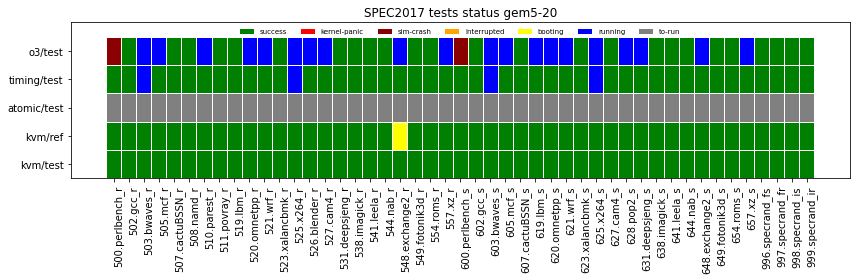

In [13]:
for gem5 in gem5_version:
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 12
    fig_size[1] = 4
    doplot_status(gem5)
    plt.yticks([0.5,1.5,2.5,3.5,4.5], ('kvm/test', 'kvm/ref', 'atomic/test', 'timing/test', 'o3/test'))
    plt.ylim(ymax = 5.5, ymin = 0)
    plt.legend(loc=9, ncol=7, prop={'size': 7}, frameon=0)
    plt.title('SPEC2017 tests status {}'.format(gem5))
    plt.tight_layout()
    plt.savefig(plotdir + 'spec2017_new_{}_status'.format(gem5) + '.png', format='png', dpi=600)